In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-30,-0.002078,-0.000401,0.000355,920.382019,0.285540,0.000964,0.003887,-0.046710,51.132956,1.003820,...,882.626665,0,-0.007057,0.057605,-0.002272,0.004646,0.991261,0.002001,0.004457,1.006902
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,0.005657,60.627504,1.185684,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003820,-0.002272,0.004646,0.991261
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,0.025966,63.472551,1.046927,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.185684,0.000964,0.003887,1.003820


In [3]:
# Add the prediction target
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [4]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([2064], dtype=int64), array([21], dtype=int64))

In [5]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-21,-0.033476,0.003682,-0.027807,18547.400391,0.260182,-0.018178,0.075686,21.451423,36.301870,0.949552,...,2,-0.125733,0.040995,-0.033429,0.041938,0.906138,0.006417,0.067925,1.026282,1.0
2022-09-22,-0.018878,-0.011066,0.006849,19413.550781,-0.112761,0.046699,0.056545,22.498496,43.978781,1.211474,...,3,-0.085071,0.041781,-0.018178,0.075686,0.949552,-0.033429,0.041938,0.906138,1.0
2022-09-23,0.047357,0.000399,0.010967,19297.638672,-0.054446,-0.005971,0.045501,22.357409,43.227946,0.982927,...,4,-0.084860,0.042373,0.046699,0.056545,1.211474,-0.018178,0.075686,0.949552,0.0
2022-09-24,-0.005945,-0.007936,0.013129,18937.011719,-0.327705,-0.018688,0.023763,21.920066,40.888991,0.945893,...,5,-0.113171,0.042498,-0.005971,0.045501,0.982927,0.046699,0.056545,1.211474,0.0
2022-09-25,-0.018691,-0.009087,-0.008775,18802.097656,-0.106681,-0.007124,0.023441,21.758957,40.016659,0.978666,...,6,-0.058220,0.040630,-0.018688,0.023763,0.945893,-0.005971,0.045501,0.982927,0.0


In [6]:
# Train Test Split
# Remove unwanted columns
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)

In [7]:
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [8]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (1652, 16)
Shape of y_train:  (1652,)


In [9]:
# build initial model to fine tune hyperparameters
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [10]:
# Determine Objective and Eval Metrics for xgboost
if is_binary:
    objective = "binary:logistic"
    # next line not needed but we can keep it for testing
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    # next line not needed but we can keep it for testing
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [13]:
# Provide Gris for Hyperparams in order to search for the best
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [14]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 200, lr: 0.05 md: 1 gm: 0.1


In [15]:
# Train the model
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [16]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [17]:
# Evaluate the model
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 0 0 1]


In [18]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [19]:
# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [20]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("")
print("Just for reference. Right now, we are only focussed on getting some initial features.")
print("If the results look too good to be true, they probably are.")

Average Accuracy K-Fold:  0.68
Std Deviation K-Fold:  0.05
Precision Score 0:  0.712
Precision Score 1:  0.782

Just for reference. Right now, we are only focussed on getting some initial features.
If the results look too good to be true, they probably are.


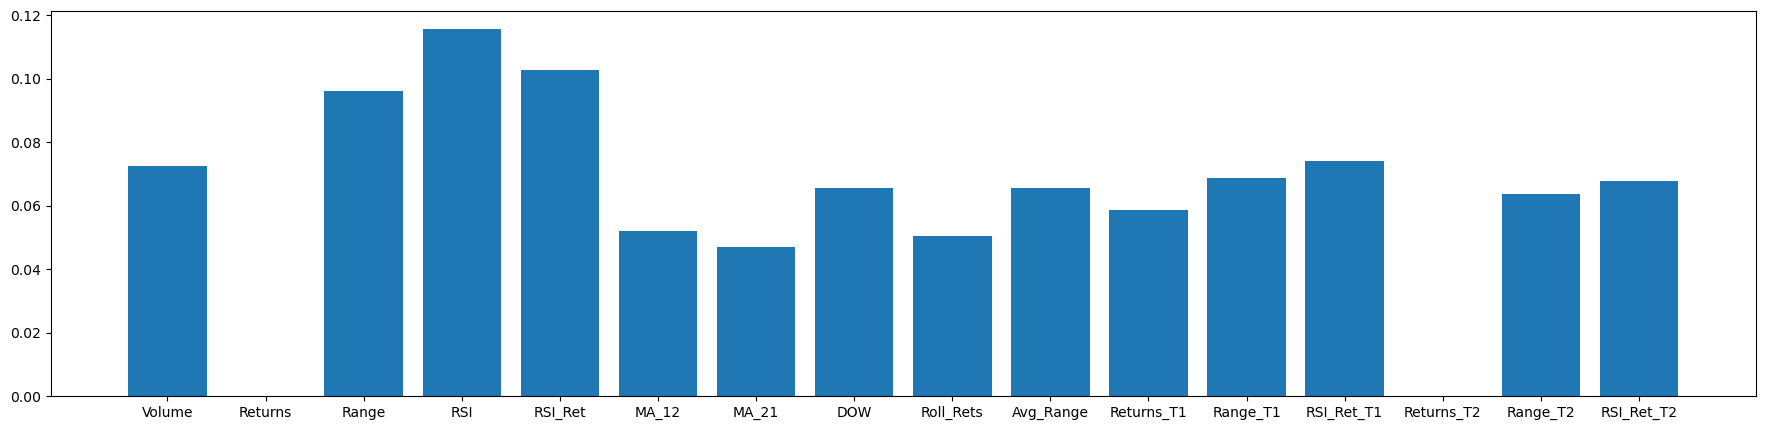

In [21]:
# Feature selection
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [22]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

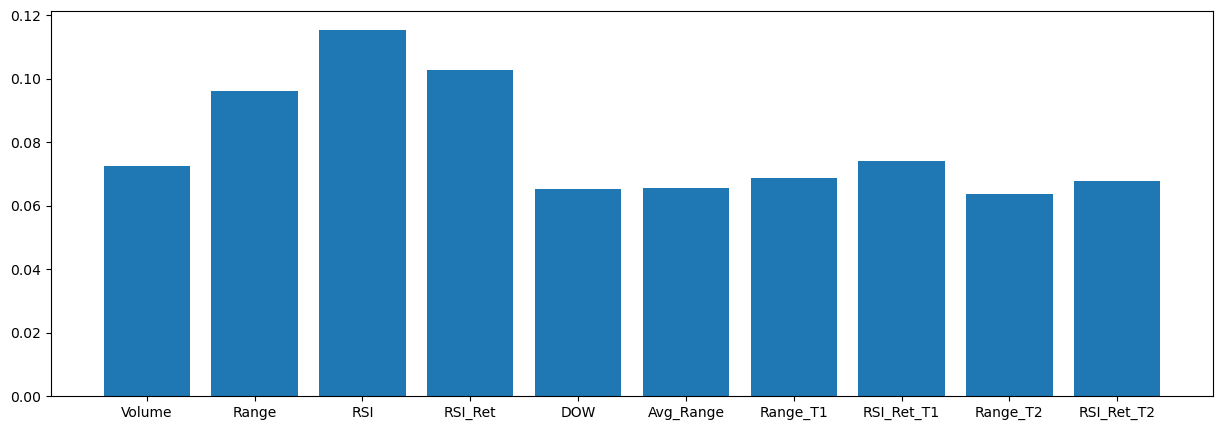

In [23]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()